In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [2]:
import h5py
import numpy as np
particle_data_path ='dataset/brightfield_particles.hdf5'
with h5py.File(particle_data_path , 'r') as f:
    print(f['data'].shape)
    print(np.unique(f['labels'],return_counts=True))

(27282, 16, 201)
(array([0, 1, 2]), array([22076,  5146,    60]))


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
# from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torchvision.models.vision_transformer import VisionTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

In [4]:
       
def compute_normalization_stats(h5_path, classes=None):
    """
    Compute mean and standard deviation for z-score normalization.
    
    Args:
        h5_path (str): Path to HDF5 file
        classes (list, optional): List of classes to include in computation
        
    Returns:
        tuple: (mean, std) computed across all data points
    """
    with h5py.File(h5_path, 'r') as h5_file:
        data = h5_file['data'][:]
        labels = h5_file['labels'][:]
        
        if classes is not None:
            # Filter data for selected classes
            mask = np.isin(labels, classes)
            data = data[mask]
        
        # Compute statistics across all dimensions
        mean = np.mean(data)
        std = np.std(data)
        
        print(f"Computed statistics: mean = {mean:.4f}, std = {std:.4f}")
        
        return mean, std
        
class ParticleDataset(Dataset):
    """Custom Dataset for particle data with flexible class selection and normalization."""
    def __init__(self, h5_path, classes=[0, 1], transform=None, mean=None, std=None,padding=False):
        self.h5_file = h5py.File(h5_path, 'r')
        data = self.h5_file['data'][:]
        labels = self.h5_file['labels'][:]
        self.padding = padding
        # Filter data for selected classes
        mask = np.isin(labels, classes)
        self.data = data[mask][:10000]
        self.labels = labels[mask][:10000]
        
        # Create class mapping to handle non-consecutive class indices
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.num_classes = len(classes)
        
        # Map original labels to new consecutive indices
        self.labels = np.array([self.class_to_idx[label] for label in self.labels])
        
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get particle data
        particle = self.data[idx]  # Shape: (16, 201)
        
        # Apply normalization if mean and std are provided
        if self.mean is not None and self.std is not None:
            particle = (particle - self.mean) / self.std
        
        # Convert to torch tensor for better interpolation
        particle_tensor = torch.FloatTensor(particle).unsqueeze(0)  # Add channel dim
        
        # Resize to (16, 16) using bicubic interpolation
        resized = torch.nn.functional.interpolate(
            particle_tensor.unsqueeze(0),  # Add batch dim
            size=(16, 201),
            mode='bicubic',
            align_corners=True
        ).squeeze(0).squeeze(0)  # Remove batch and channel dims
        
        final_tensor = resized.unsqueeze(0).repeat(3, 1, 1)  # Repeat across 3 channels
        
        if self.transform:
            final_tensor = self.transform(final_tensor)
        
        # Create one-hot encoded label
        label_idx = self.labels[idx]
        label_onehot = torch.zeros(self.num_classes)
        label_onehot[label_idx] = 1
        
        return final_tensor, label_onehot

    def close(self):
        self.h5_file.close()     

In [5]:
import torch 

def distance_matrix(a, b):
    a_expanded = a.view(-1, 1)
    b_expanded = b.view(1, -1)

    return torch.abs(a_expanded - b_expanded)

def knn_divergence(points_x, points_y, k, smoothing_kernel=None):
    xx_distances = distance_matrix(points_x, points_x)
    xy_distances = distance_matrix(points_x, points_y) # one row for every sample in x, one col for every sample in y
    # print(xx_distances.shape, xy_distances.shape)
    # if the sets have different sizes
    # e.g. y has twice as many points -> the distance to the 3rd closest point in x should be the same as the distance to the 6th point in y
    k_multiplier = points_y.shape[0] / points_x.shape[0]

    k_dist_xx = torch.sort(xx_distances, dim=1)[0][:, k]
    k_dist_xy = torch.sort(xy_distances, dim=1)[0][:, (k * k_multiplier).to(torch.int)]

    # optional: smoothen the distances 
    # (so that it matters less whether a point is the i-th or the (i+1)-th closest neighbor)
    if smoothing_kernel != None:
            # torch conv1d demands a channel dimension, hence the (un)squeezing
            k_dist_xx = torch.nn.functional.conv1d(k_dist_xx.unsqueeze(1), weight=smoothing_kernel.view(1, 1, -1)).flatten(1)
            k_dist_xy = torch.nn.functional.conv1d(k_dist_xy.unsqueeze(1), weight=smoothing_kernel.view(1, 1, -1)).flatten(1)

    # return torch.mean((1 - k_dist_xx / k_dist_xy)**2)
    return torch.mean((k_dist_xx - k_dist_xy)**2)

In [6]:
from torchsummary import summary

In [7]:
# resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# # resnet .fc = nn.Linear(resnet.fc.in_features, 1)
# resnet .fc = nn.Sequential(
#     nn.Linear(resnet.fc.in_features, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1))

In [8]:
# summary(resnet, input_size=(3, 16, 201),device='cpu')

In [9]:
torch.manual_seed(42)
DEVICE = "cuda:11"
# Device configuration
device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# classes = [0]
mean, std = compute_normalization_stats('dataset/brightfield_particles.hdf5', classes=[0,1])
dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[0],
                          mean=mean,
                          std=std,
                          padding=True
                         )
dataset_300 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[1],
                          mean=mean,
                          std=std,
                          padding=True
                         )

Using device: cuda:11
Computed statistics: mean = 7077.7081, std = 1176.7393


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
def generate_label_distribution(num_points=10000, mean=76, std=22.5, min_value=10, max_value=None):
    """
    Generate a tensor of points sampled from a normal distribution with specified mean and standard deviation
    while rejecting points outside the optional min and max value constraints.
    
    Args:
        num_points (int): Number of points to generate
        mean (float): Mean of the distribution
        std (float): Standard deviation of the distribution
        min_value (float, optional): Minimum value of the distribution (inclusive)
        max_value (float, optional): Maximum value of the distribution (inclusive)
    
    Returns:
        torch.Tensor: Tensor of generated points within the specified range
    """
    points = torch.empty(0)  # Initialize an empty tensor to store valid points

    while points.numel() < num_points:
        # Generate points from normal distribution
        generated_points = torch.normal(mean=mean, std=std, size=(num_points,))
        
        # Filter points based on the min and max values
        if min_value is not None:
            generated_points = generated_points[generated_points >= min_value]
        if max_value is not None:
            generated_points = generated_points[generated_points <= max_value]
        
        # Add the valid points to the tensor
        points = torch.cat((points, generated_points))

    # Return only the first `num_points` points
    return points[:num_points]
batch_size = 10000
dataloader_80 = DataLoader(dataset_80, batch_size=batch_size, shuffle=True)
num_points = 10000
label_points_80 = generate_label_distribution(num_points, mean=76, std=22.5)
dataloader_300 = DataLoader(dataset_300, batch_size=5146, shuffle=True)
label_points_300 = generate_label_distribution(5146, mean=302, std=25)
label_points = (label_points_80,label_points_300)
dataloaders = (dataloader_80,dataloader_300)

In [11]:
def train_resnet(model, dataloaders, label_points, device, num_epochs=10, learning_rate=1e-2):
    """
    Train ResNet model using KNN divergence loss.
    
    Args:
        model (torch.nn.Module): ResNet model
        dataloader (torch.utils.data.DataLoader): Training dataloader
        label_points (torch.Tensor): Pre-generated label points
        device (torch.device): Device to train on
        num_epochs (int): Number of training epochs
        learning_rate (float): Learning rate for optimizer
    """
    # Move label points to the specified device
    labels_80,labels_300  = label_points
    labels_80,labels_300  = labels_80.to(device, non_blocking=True),labels_300.to(device, non_blocking=True)
    # Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    
    # Prepare k values for KNN divergence
    ks = [torch.arange(2, label_point.shape[0]//10, dtype=torch.int) for label_point in label_points]
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for idx,(labels,dataloader) in enumerate(zip([labels_80,labels_300],dataloaders)):
            if idx==0:
                for batch_images,_ in dataloader:
                    label = torch.clone(labels)
                    batch_images = batch_images.to(device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass: generate predictions
                    batch_predictions = model(batch_images)
                    
                    # Compute KNN divergence loss
                    # diff_mean = 76-torch.mean(batch_predictions)
                    # loss = knn_divergence(batch_predictions, label, k)+0.2*torch.pow(diff_mean,2)
                    loss = knn_divergence(batch_predictions, label, ks[idx])
                    # Backward pass and optimize
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                
                # Print average loss for the epoch
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')


In [12]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# resnet .fc = nn.Linear(resnet.fc.in_features, 1)
resnet .fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)
train_resnet(resnet, dataloaders, label_points, device, num_epochs=400)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/root/miniconda3/envs/iscat/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/iscat/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/400], Loss: 1468.2634
Epoch [2/400], Loss: 1053.6833
Epoch [3/400], Loss: 94.8367
Epoch [4/400], Loss: 0.4397
Epoch [5/400], Loss: 787.0761
Epoch [6/400], Loss: 2.0740
Epoch [7/400], Loss: 8.2906
Epoch [8/400], Loss: 14.7844
Epoch [9/400], Loss: 41.0484
Epoch [10/400], Loss: 85.9217
Epoch [11/400], Loss: 120.8041
Epoch [12/400], Loss: 128.2021
Epoch [13/400], Loss: 104.0108
Epoch [14/400], Loss: 66.7288
Epoch [15/400], Loss: 35.9789
Epoch [16/400], Loss: 17.2790
Epoch [17/400], Loss: 8.3637
Epoch [18/400], Loss: 4.1037
Epoch [19/400], Loss: 2.2698
Epoch [20/400], Loss: 1.5613
Epoch [21/400], Loss: 1.2404
Epoch [22/400], Loss: 1.1290
Epoch [23/400], Loss: 1.1263
Epoch [24/400], Loss: 1.2783
Epoch [25/400], Loss: 1.5242
Epoch [26/400], Loss: 2.0238
Epoch [27/400], Loss: 2.9837
Epoch [28/400], Loss: 3.9880
Epoch [29/400], Loss: 4.4531
Epoch [30/400], Loss: 4.2980
Epoch [31/400], Loss: 3.8044
Epoch [32/400], Loss: 3.6972
Epoch [33/400], Loss: 2.8498
Epoch [34/400], Loss: 2.4765
Ep

In [13]:
resnet.eval()
resnet(dataset_80[0][0].unsqueeze(0).to(device))

tensor([[74.7862]], device='cuda:11', grad_fn=<AddmmBackward0>)

In [14]:
with torch.no_grad():
    a= next(iter(dataloader_80))[0]
    out  = resnet(a.to(device))

In [18]:
out.max()

tensor(150.3526, device='cuda:11')

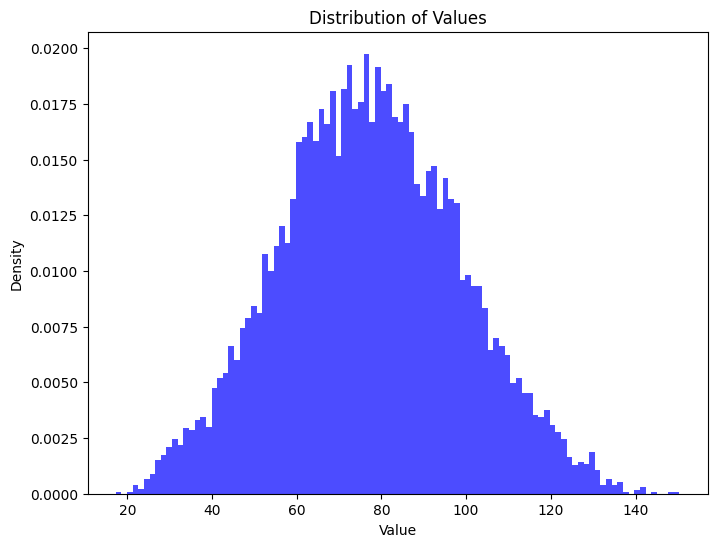

In [19]:
import matplotlib.pyplot as plt

# Example list of values
values =out.cpu().detach().numpy()
# values = o
# Set up the plot
plt.figure(figsize=(8, 6))

# Plot the histogram
plt.hist(values, bins=100, density=True, color='blue', alpha=0.7)

# Add labels
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Density')

# Show plot
plt.show()


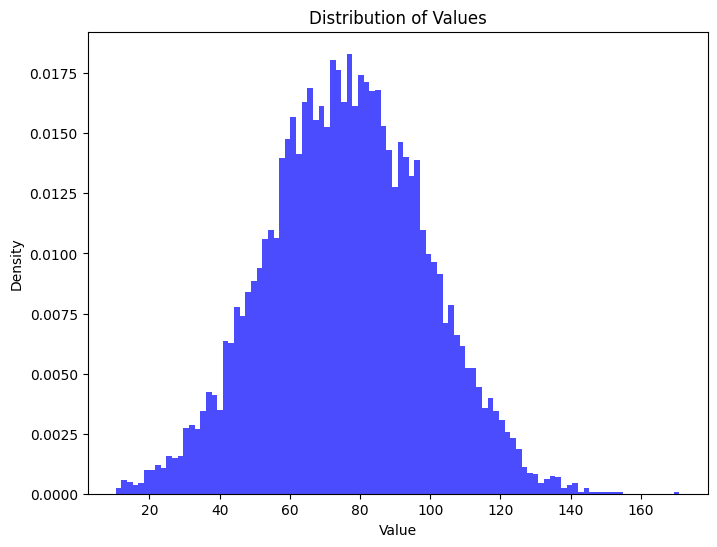

In [20]:
import matplotlib.pyplot as plt

# Example list of values
values = label_points_80
# values = o
# Set up the plot
plt.figure(figsize=(8, 6))

# Plot the histogram
plt.hist(values, bins=100, density=True, color='blue', alpha=0.7)

# Add labels
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Density')

# Show plot
plt.show()


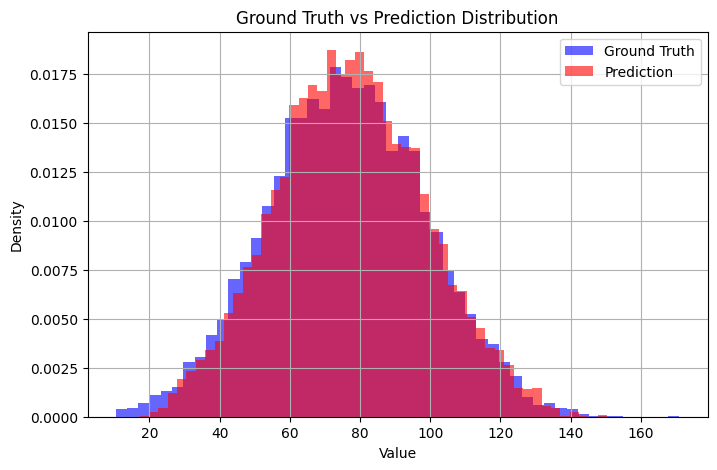

In [21]:
# Plot histograms
plt.figure(figsize=(8, 5))
plt.hist(label_points_80 , bins=50, alpha=0.6, label='Ground Truth', color='blue', density=True)
plt.hist(out.cpu().detach().numpy(), bins=50, alpha=0.6, label='Prediction', color='red', density=True)

# Labels and legend
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Ground Truth vs Prediction Distribution')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [22]:
with torch.no_grad():
    out_2 = next(iter(dataloader_300))[0]
    out_2  = resnet(out_2.to(device))

In [27]:
out_2.mean()

tensor(229.5561, device='cuda:11')

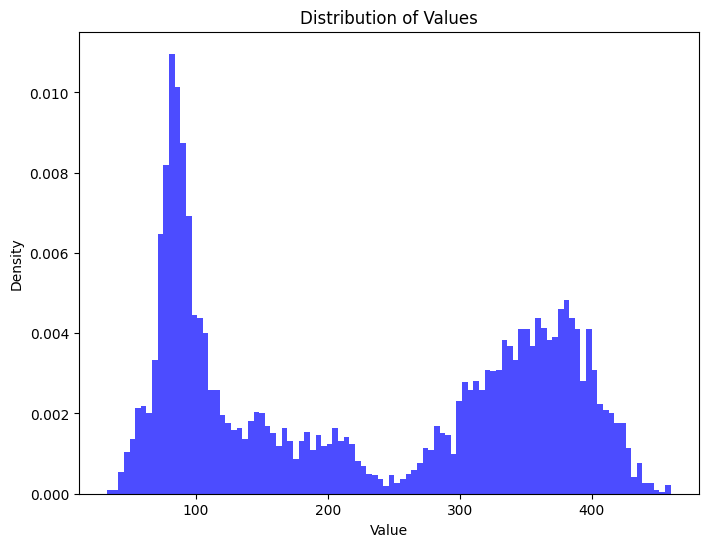

In [26]:
import matplotlib.pyplot as plt

# Example list of values
values =out_2.cpu().detach().numpy()
# values = o
# Set up the plot
plt.figure(figsize=(8, 6))

# Plot the histogram
plt.hist(values, bins=100, density=True, color='blue', alpha=0.7)

# Add labels
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Density')

# Show plot
plt.show()


In [ ]:
resnet(dataset_80[0][0].unsqueeze(0).to(device))

In [104]:
with torch.no_grad():
    output_map = resnet.conv1(dataset_80[0][0].unsqueeze(0).to(device)).squeeze(0).cpu()

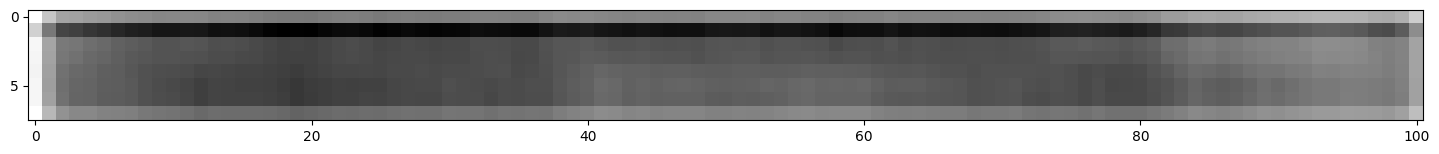

In [110]:
fig, ax = plt.subplots(figsize=(18, 10))
f=torch.clone(output_map[32])
# f[f<(f.mean())]=0
ax.imshow(f,cmap='gray')
plt.show()

torch.Size([363])

In [55]:
img1 = dataset_80[0][0]
img2 = dataset_80[1][0]
size_1 = resnet(img1.unsqueeze(0).to(device)).cpu()
size_2 = resnet(img2.unsqueeze(0).to(device)).cpu()

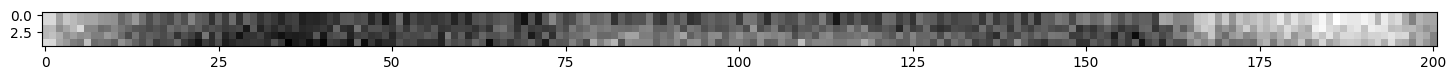

In [75]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.imshow(img1[0][5:10],cmap='gray')
plt.show()

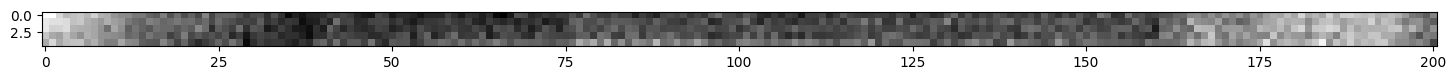

In [76]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.imshow(img2[0][5:10],cmap='gray')
plt.show()

In [141]:
resnet_partial = torch.nn.Sequential(*list(resnet.children())[:-1])

In [223]:
with torch.no_grad():
    imgs = next(iter(dataloader_80))[0]  # (10000,3,16,201)
    img = imgs[3000].unsqueeze(0)  # (1,3,16,201)
    
    # Get prediction for original image
    size_1 = resnet(img.to(device)).cpu()
    size_1 = size_1.squeeze(0)
    
    # Flip the image horizontally (along the last dimension)
    img_flipped = torch.flip(img, dims=[-1])
    
    # Get prediction for flipped image
    size_2 = resnet(img_flipped.to(device)).cpu()
    size_2 = size_2.squeeze(0)
    
    # Print both predictions
    print(f"Original image size prediction: {size_1.item():.3f}")
    print(f"Flipped image size prediction: {size_2.item():.3f}")
    print(f"Absolute difference: {abs(size_1.item() - size_2.item()):.3f}")

Original image size prediction: 55.034
Flipped image size prediction: 59.088
Absolute difference: 4.054


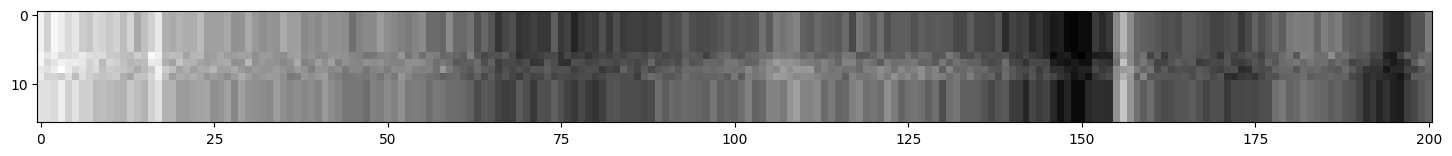

In [230]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.imshow(imgs[0][0],cmap='gray')
plt.show()

In [231]:
with torch.no_grad():
    imgs = next(iter(dataloader_80))[0]  # (10000,3,16,201)
    sizes = resnet(imgs.to(device)).cpu() 

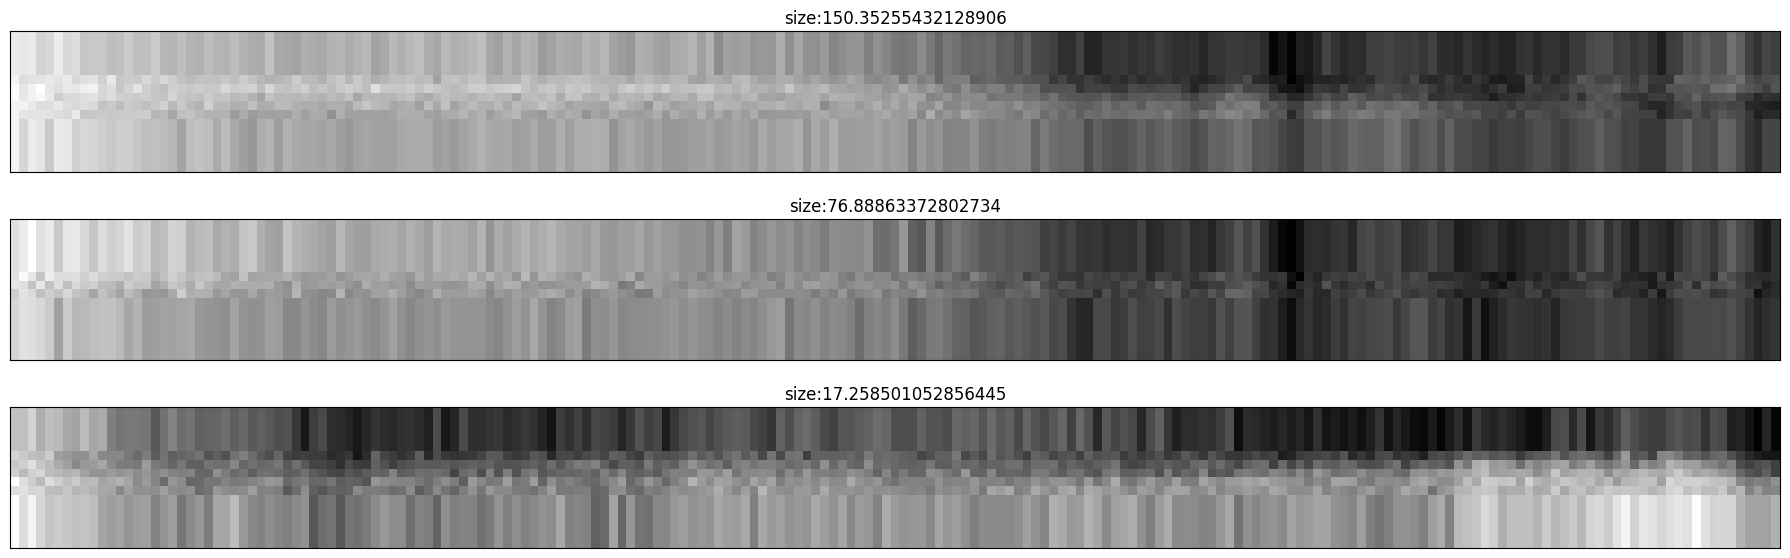

In [267]:
max_size, max_idx = sizes.max(axis=0)
min_size, min_idx = sizes.min(axis=0)
# Find the middle/mode value
mid_size = sizes.median()  # or use mode() if you prefer mode
mid_idx = (sizes - mid_size).abs().argmin()  # find closest to median

max_img = imgs[max_idx].squeeze(0)[0]
min_img = imgs[min_idx].squeeze(0)[0]
mid_img = imgs[mid_idx].squeeze(0)[0]

# Create 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 6))

# Plot max image
ax1.imshow(max_img, cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.title.set_text(f"size:{max_size.item()}")

# Plot mid image
ax2.imshow(mid_img, cmap='gray')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.title.set_text(f"size:{mid_size.item()}")

# Plot min image
ax3.imshow(min_img, cmap='gray')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.title.set_text(f'size:{min_size.item()}')

# Remove spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)
plt.tight_layout()
plt.show()

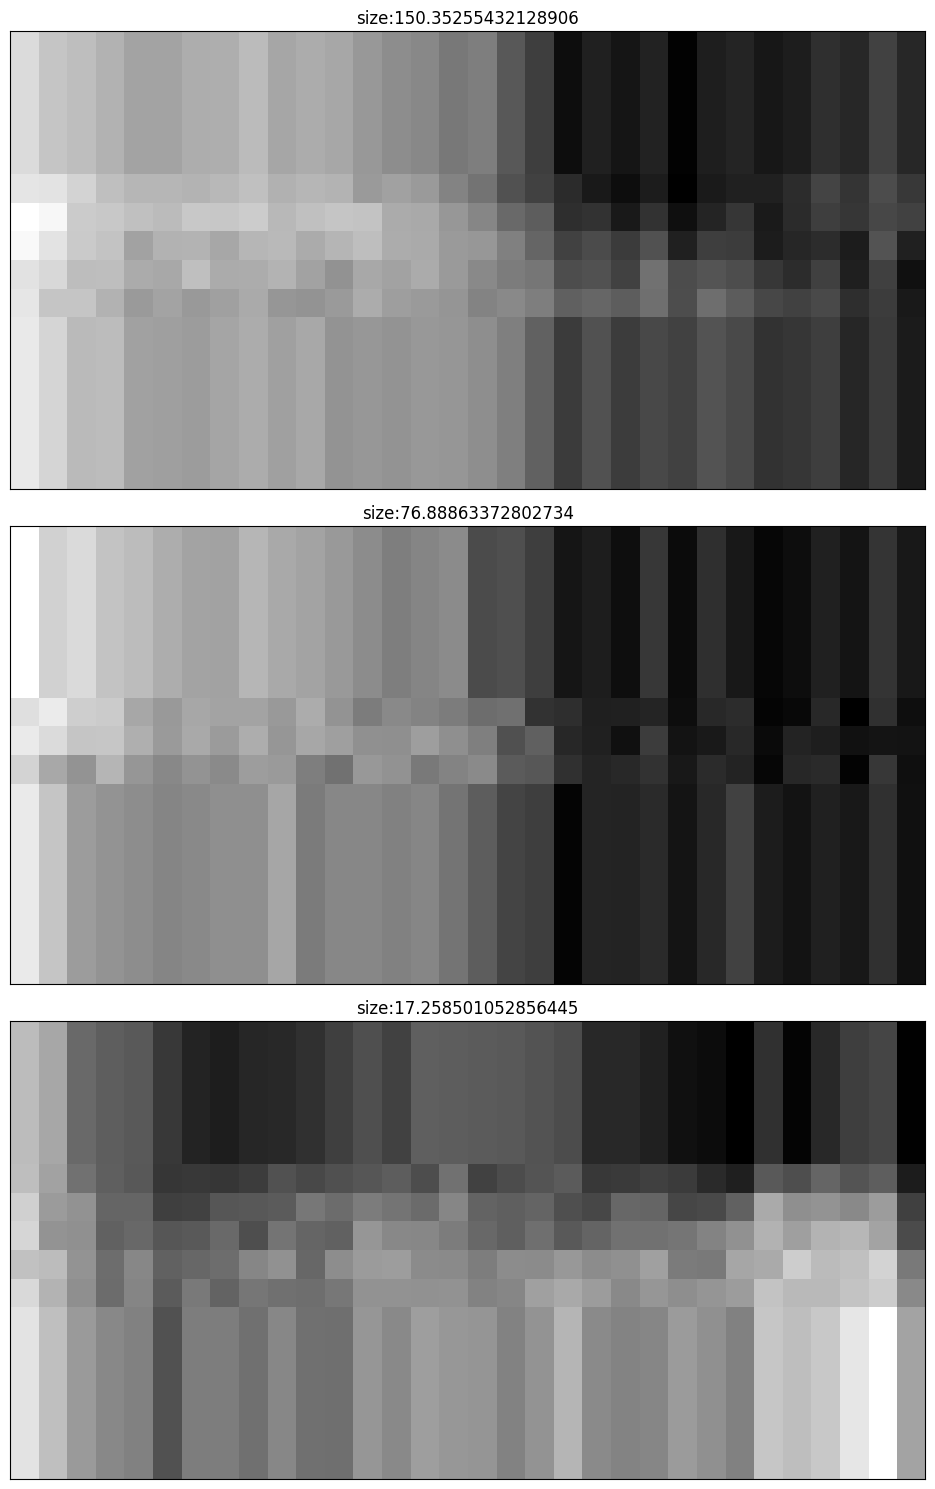

In [311]:
max_size, max_idx = sizes.max(axis=0)
min_size, min_idx = sizes.min(axis=0)
# Find the middle/mode value
mid_size = sizes.median()  # or use mode() if you prefer mode
mid_idx = (sizes - mid_size).abs().argmin()  # find closest to median
mid_idx= torch.Tensor([mid_idx]).to(torch.int64)
# Get images, select first channel and reshape correctly before resizing
max_img = torch.nn.functional.interpolate(imgs[max_idx][0:1], size=(16, 32), mode='bilinear', align_corners=False).squeeze(0)[0]
min_img = torch.nn.functional.interpolate(imgs[min_idx][0:1], size=(16, 32), mode='bilinear', align_corners=False).squeeze(0)[0]
mid_img = torch.nn.functional.interpolate(imgs[mid_idx][0:1], size=(16, 32), mode='bilinear', align_corners=False).squeeze(0)[0]

# Create 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 15))

# Plot max image
ax1.imshow(max_img, cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.title.set_text(f"size:{max_size.item()}")

# Plot mid image
ax2.imshow(mid_img, cmap='gray')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.title.set_text(f"size:{mid_size.item()}")

# Plot min image
ax3.imshow(min_img, cmap='gray')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.title.set_text(f'size:{min_size.item()}')

# Remove spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)
plt.tight_layout()
plt.show()